# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [ ]:
# @title Install dependencies
!pip install nilearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 45.9 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Necessary for visualization
from nilearn import plotting, datasets

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./DATA"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquisition
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [ ]:
# @title Download the data

# @markdown Task data in `HCP_DIR/hcp_task`, rest in `HCP_DIR/hcp_rest`, covariate in `HCP_DIR/hcp`

import os, requests, tarfile

fnames = ["hcp_rest.tgz",
          "hcp_task.tgz",
          "hcp_covariates.tgz",
          "atlas.npz"]
urls = ["https://osf.io/bqp7m/download",
        "https://osf.io/s4h8j/download",
        "https://osf.io/x5p4g/download",
        "https://osf.io/j5kuc/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

Download hcp_rest.tgz completed!
Download hcp_task.tgz completed!
Download hcp_covariates.tgz completed!
Download atlas.npz completed!


In [ ]:
# @title Extract the data in `HCP_DIR`
fnames = ["hcp_covariates", "hcp_rest", "hcp_task"]

for fname in fnames:
  # open file
  path_name = os.path.join(HCP_DIR, fname)
  if not os.path.exists(path_name):
    print(f"Extracting {fname}.tgz...")
    with tarfile.open(f"{fname}.tgz") as fzip:
      fzip.extractall(HCP_DIR)
  else:
    print(f"File {fname}.tgz has already been extracted.")

Extracting hcp_covariates.tgz...
Extracting hcp_rest.tgz...
Extracting hcp_task.tgz...


## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [ ]:
dir = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
regions = np.load(os.path.join(dir, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   myelin=regions[2].astype(float)
                   )

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [ ]:
with np.load(f"atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Resting-state analyses

Load a single run of resting-state data:

In [ ]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, dir, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      dir (str) : data directory
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [ ]:
timeseries = load_timeseries(subject=0,
                             name="rest",
                             dir=os.path.join(HCP_DIR, "hcp_rest"),
                             runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [ ]:
timeseries_rest = []
for subject in subjects[:100]:
  ts_concat = load_timeseries(subject, name="rest",
                              dir=os.path.join(HCP_DIR, "hcp_rest"),runs=1)
  timeseries_rest.append(ts_concat)
timeseries_rest = np.asarray(timeseries_rest)


timeseries_WM = []
for subject in subjects:
  ts_concat = load_timeseries(subject, name="WM",
                              dir=os.path.join(HCP_DIR, "hcp_task"))
  timeseries_WM.append(ts_concat)
timeseries_WM = np.asarray(timeseries_WM)

#PCA

In [ ]:
# Reshape timeseries_rest: concatenate all subjects in time
N_subjects, N_parcels, T = timeseries_rest.shape
rest_all = timeseries_rest.transpose(0, 2, 1).reshape(-1, N_parcels)  # shape: (N_subjects*T, 360)
print(timeseries_rest.shape)

(100, 360, 1200)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


scaler = StandardScaler()
rest_all_scaled = scaler.fit_transform(rest_all)  # standardize across time

n_components = 4
pca = PCA(n_components=n_components)
pca.fit(rest_all_scaled)

rest_states = pca.components_  # shape: (4, 360)

Shape of state_mean_bold_patterns: (4, 360)
Using shared color scale: vmin=-0.09, vmax=0.15


/tmp/ipython-input-17-2949038980.py:35: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(
/tmp/ipython-input-17-2949038980.py:48: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(
/tmp/ipython-input-17-2949038980.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


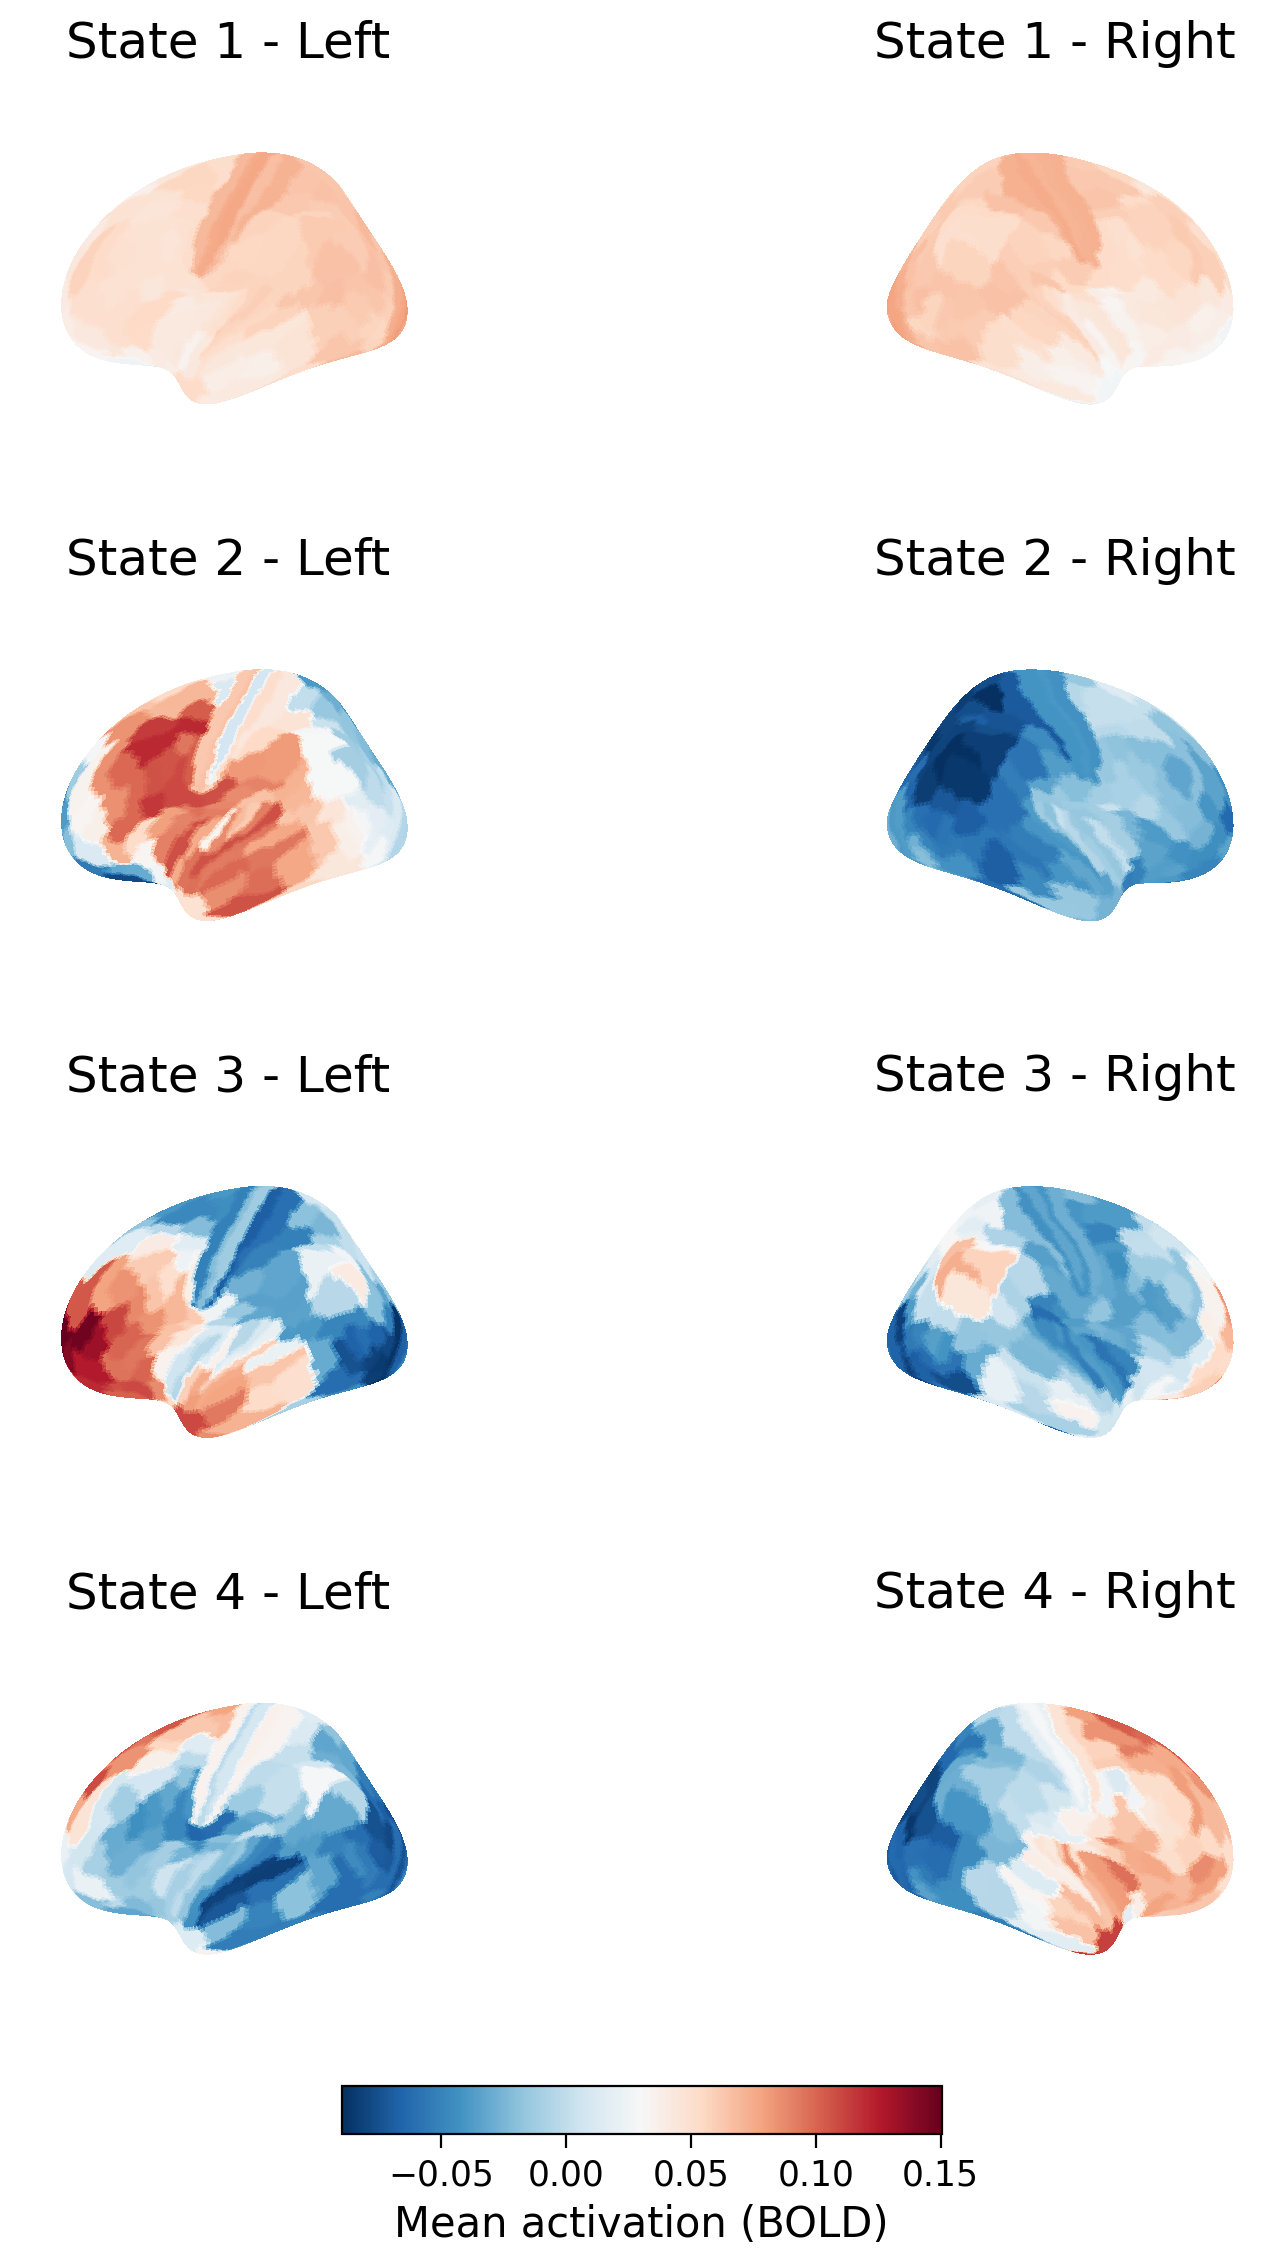

In [ ]:
## - import dependencies
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.pyplot as plt
from nilearn import datasets, plotting
import numpy as np

## - TODO replace your_brain_state_matrix_name with your brain state matrix (should be shape: n_states x 360)
#

state_mean_bold_patterns = rest_states

# Load fsaverage template surfaces
fsaverage = datasets.fetch_surf_fsaverage()

# Inspect data shape
print("Shape of state_mean_bold_patterns:", state_mean_bold_patterns.shape)
n_states = state_mean_bold_patterns.shape[0]

# Compute global vmin and vmax across all latent states
vmin = np.min(state_mean_bold_patterns)
vmax = np.max(state_mean_bold_patterns)
print(f"Using shared color scale: vmin={vmin:.2f}, vmax={vmax:.2f}")

# Plot a n_states by 2 columns image to show each of the unique brain states
fig, axes = plt.subplots(n_states, 2, figsize=(10, 12), subplot_kw={'projection': '3d'})

for state_idx in range(n_states):
    bold_pattern = state_mean_bold_patterns[state_idx]

    bold_L = bold_pattern[atlas["labels_L"]]
    bold_R = bold_pattern[atlas["labels_R"]]

    # left hemisphere
    plotting.plot_surf_stat_map(
        fsaverage["infl_left"],
        bold_L,
        hemi='left',
        colorbar=False,
        title=f"State {state_idx + 1} - Left",
        axes=axes[state_idx, 0],
        figure=fig,
        vmax=vmax,
        vmin=vmin
    )

    # right hemisphere
    plotting.plot_surf_stat_map(
        fsaverage["infl_right"],
        bold_R,
        hemi='right',
        colorbar=False,
        title=f"State {state_idx + 1} - Right",
        axes=axes[state_idx, 1],
        figure=fig,
        vmax=vmax,
        vmin=vmin
    )


# Add cbar to bottom
cax = fig.add_axes([0.35, 0.1, 0.3, 0.02])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cb = colorbar.ColorbarBase(cax, cmap="RdBu_r", norm=norm, orientation='horizontal')
cb.set_label("Mean activation (BOLD)")

plt.tight_layout(rect=[0, 0.12, 1, 1])
plt.show()

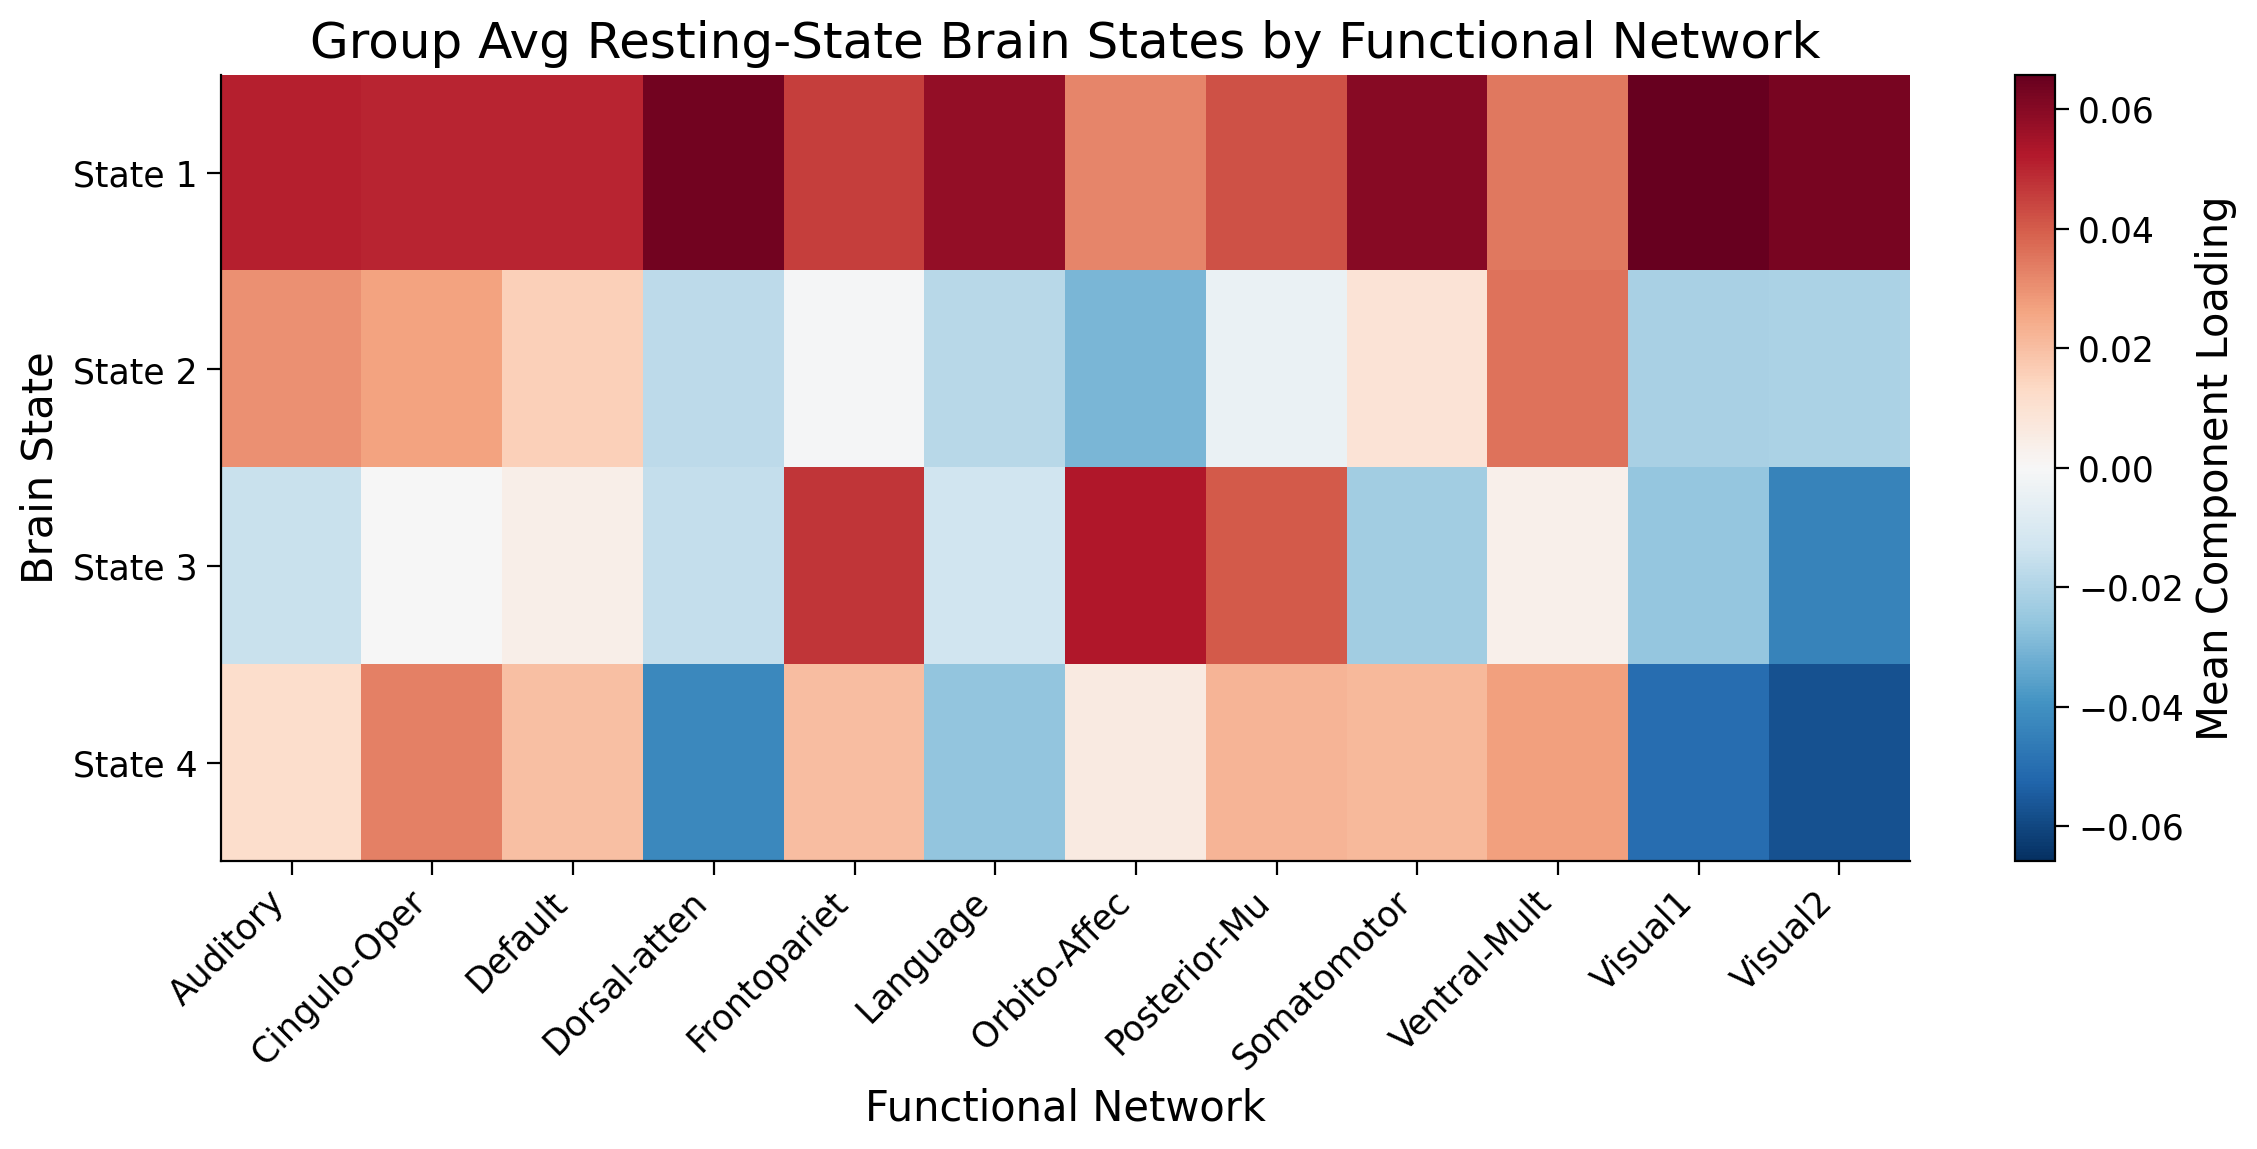

In [ ]:

"""
Plot brain state patterns by functional network
"""
networks = np.array(region_info['network'])
unique_networks = np.unique(networks)
n_states = rest_states.shape[0]

# Calculate mean loading for each network
network_loadings = np.zeros((n_states, len(unique_networks)))

for i, network in enumerate(unique_networks):
  network_mask = networks == network
  network_loadings[:, i] = np.mean(rest_states[:, network_mask], axis=1)

# Create heatmap
plt.figure(figsize=(12, 6))
# States on y-axis, networks on x-axis
im = plt.imshow(network_loadings,
              cmap='RdBu_r',
              aspect='auto',
              vmin=-np.max(np.abs(network_loadings)),
              vmax=np.max(np.abs(network_loadings)))

plt.colorbar(im, label='Mean Component Loading')
# States on y-axis
plt.yticks(range(n_states), [f'State {i+1}' for i in range(n_states)])
# Networks on x-axis, rotate for readability
plt.xticks(range(len(unique_networks)), unique_networks, rotation=45, ha='right')
plt.ylabel('Brain State')
plt.xlabel('Functional Network')

# Update title based on subject_id
plt.title('Group Avg Resting-State Brain States by Functional Network')

plt.tight_layout()
plt.show()



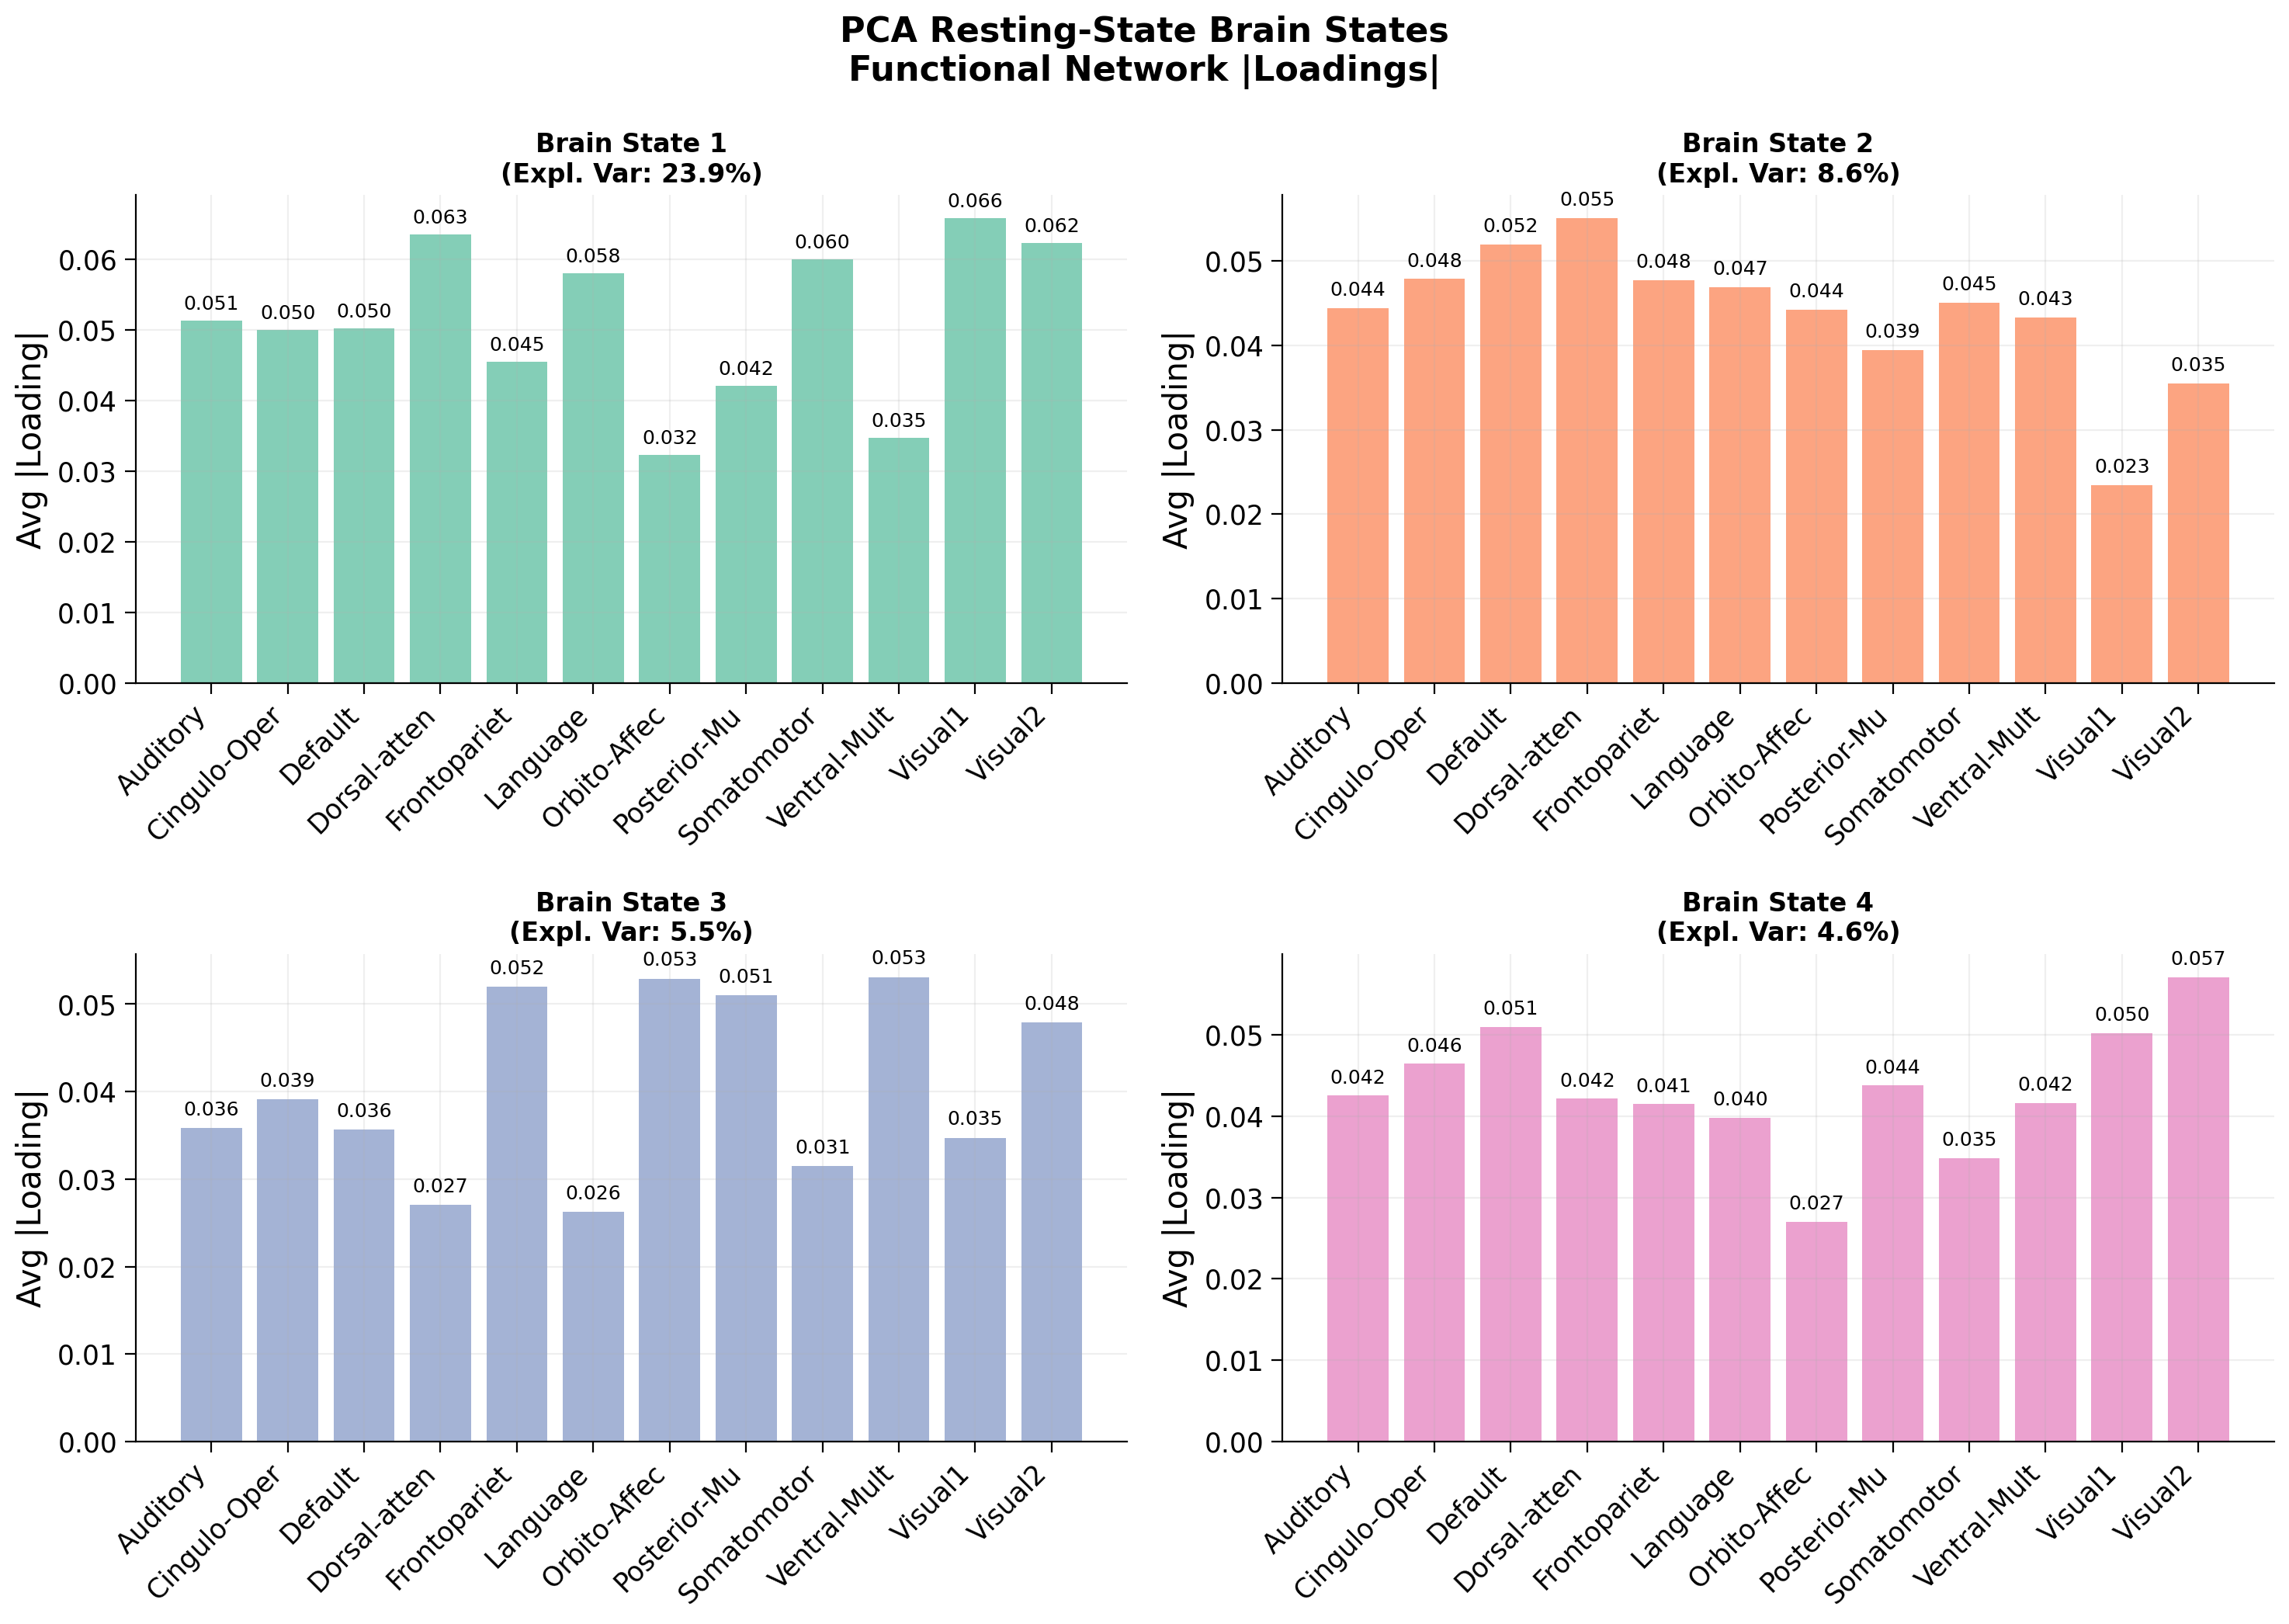

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Input:
# - rest_states: shape (n_states, 360)
# - region_info: dictionary with key "network" of length 360

n_states = rest_states.shape[0]
networks = np.array(region_info['network'])
unique_networks = np.unique(networks)
n_networks = len(unique_networks)

# Compute absolute average loadings per network
network_loadings_abs = np.zeros((n_states, n_networks))

for i in range(n_states):  # each PCA component
    for j, network in enumerate(unique_networks):
        network_mask = (networks == network)
        network_loadings_abs[i, j] = np.mean(np.abs(rest_states[i, network_mask]))

# Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # adjust if you have != 4 states
axes = axes.flatten()

for i in range(n_states):
    ax = axes[i]
    bars = ax.bar(range(n_networks),
                  network_loadings_abs[i],
                  alpha=0.8,
                  color=plt.cm.Set2(i))

    ax.set_title(f'Brain State {i+1}\n(Expl. Var: {pca.explained_variance_ratio_[i]:.1%})',
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('Avg |Loading|')
    ax.set_xticks(range(n_networks))
    ax.set_xticklabels(unique_networks, rotation=45, ha='right')
    ax.grid(True, alpha=0.2)

    # Add value labels
    for bar, val in zip(bars, network_loadings_abs[i]):
        ax.text(bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.001,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.suptitle('PCA Resting-State Brain States\nFunctional Network |Loadings|',
             fontsize=16, fontweight='bold', y=1.05)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Assume this is your matrix of shape (4, 360)
# Each row = 1 brain state (PCA component)
# Variable name: rest_states
# Shape: (n_states=4, n_parcels=360)

# Create a DataFrame
df = pd.DataFrame(rest_states)

# Add headers (optional)
df.columns = [f"Parcel_{i+1}" for i in range(360)]
df.index = [f"State_{i+1}" for i in range(4)]

# Save to CSV
df.to_csv("pca_brain_states.csv")

print("Saved to 'pca_brain_states.csv'")

Saved to 'pca_brain_states.csv'


In [ ]:
pca_states = pd.read_csv('madion-tsne-formatted.csv', header=None).values  # shape (4, 360)
print(pca_states.shape)
hmm_states = pd.read_csv('dFC_kmeans_states_by_360_parcels_n100.csv', header=None).values  # shape (4, 360)
print(hmm_states.shape)

(4, 360)
(4, 360)


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt

def compare_brain_states(csv_file_1, csv_file_2, method1_name="Method1", method2_name="Method2", metric="correlation"):
    """
    Compare brain states from two methods using similarity and Hungarian alignment.

    Parameters:
        csv_file_1 (str): Path to first CSV file (rows = states, columns = parcels).
        csv_file_2 (str): Path to second CSV file.
        method1_name (str): Name of the first method (e.g., "PCA").
        method2_name (str): Name of the second method (e.g., "HMM").
        metric (str): Distance metric to use for similarity ("correlation", "cosine", etc.)
    """
    # Load data
    states1 = pd.read_csv(csv_file_1, header=None).values
    states2 = pd.read_csv(csv_file_2, header=None).values

    # Ensure same number of states and parcels
    assert states1.shape[1] == states2.shape[1], "Mismatch in number of parcels (columns)."
    assert states1.shape[0] == states2.shape[0], "Mismatch in number of states (rows)."

    n_states = states1.shape[0]

    # Compute similarity matrix (higher is better)
    similarity_matrix = 1 - cdist(states1, states2, metric=metric)

    # Hungarian alignment to maximize total similarity
    cost_matrix = -similarity_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    aligned_states2 = states2[col_ind]

    # Print mapping
    print(f"\nBest matching states ({method1_name} i → {method2_name} j):")
    for i, j in zip(row_ind, col_ind):
        print(f"  {method1_name} State {i+1} ↔ {method2_name} State {j+1} | Sim = {similarity_matrix[i, j]:.3f}")

    # Plot heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm',
                xticklabels=[f'{method2_name} {i+1}' for i in range(n_states)],
                yticklabels=[f'{method1_name} {i+1}' for i in range(n_states)],
                vmin=-1, vmax=1)
    plt.title(f"Similarity Between {method1_name} and {method2_name} Brain States")
    plt.xlabel(f"{method2_name} States")
    plt.ylabel(f"{method1_name} States")
    plt.tight_layout()
    plt.show()

    return similarity_matrix, aligned_states2


Best matching states (pca i → tsne j):
  pca State 1 ↔ tsne State 2 | Sim = 0.864
  pca State 2 ↔ tsne State 1 | Sim = 0.369
  pca State 3 ↔ tsne State 4 | Sim = 0.511
  pca State 4 ↔ tsne State 3 | Sim = 0.247


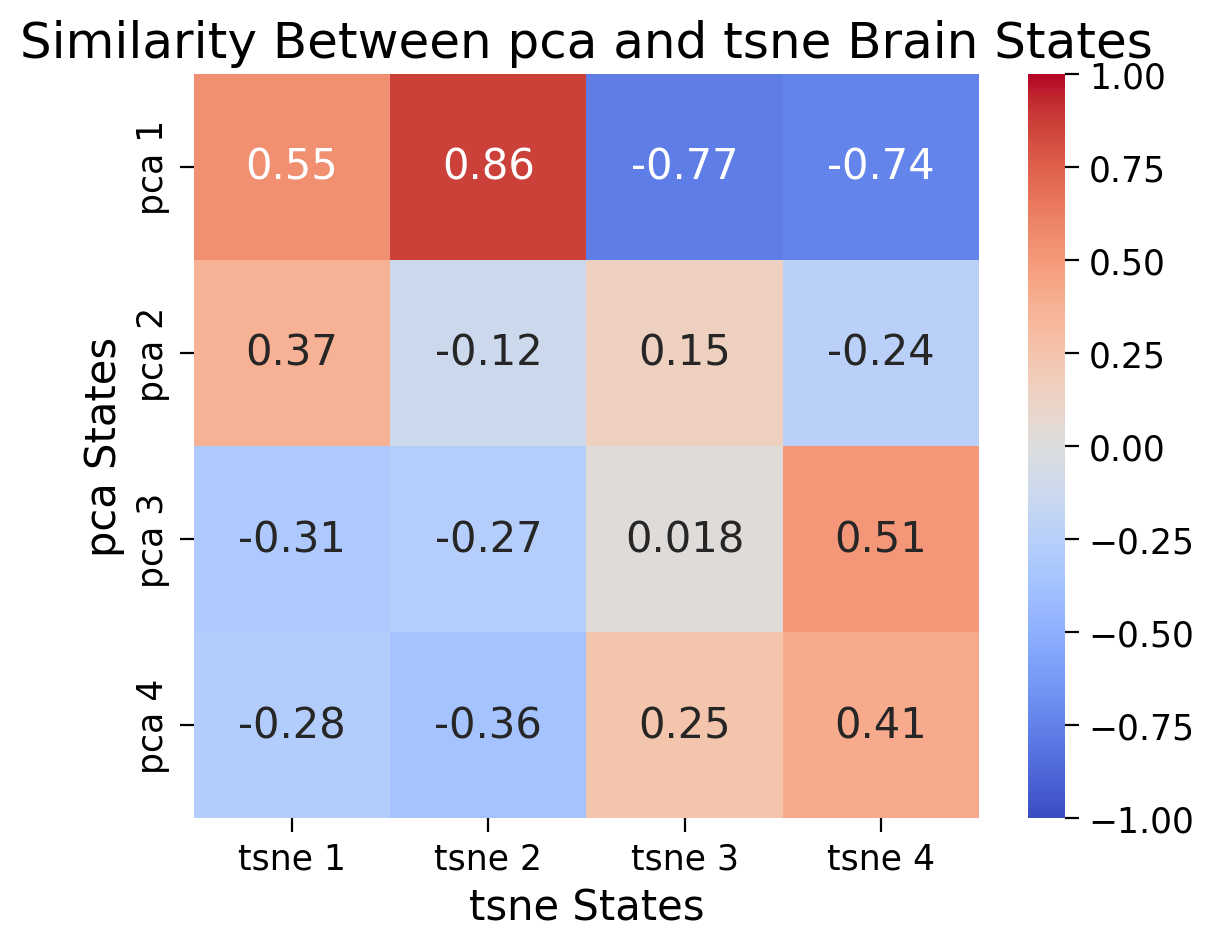

(array([[ 0.55187148,  0.86436387, -0.77103333, -0.73803901],
        [ 0.36906643, -0.11818301,  0.15430656, -0.23976642],
        [-0.3125913 , -0.26901198,  0.01833082,  0.51148829],
        [-0.28484335, -0.3646676 ,  0.24692384,  0.41013385]]),
 array([[ 0.65430814,  0.52012566,  0.69653703, ...,  0.38933745,
          0.49649855,  0.41774977],
        [ 0.61381698, -0.04025547,  0.33425415, ...,  0.88011194,
          0.65645679, -0.70233166],
        [-0.11817343, -0.05969856, -0.08610686, ..., -0.07859217,
         -0.07203274,  0.00756336],
        [-0.83387517, -0.67558403, -0.94898562, ..., -0.55590649,
         -0.71266078, -0.59395159]]))

In [ ]:
compare_brain_states("pca_brain_states.csv", "madion-tsne-formatted.csv", method1_name="pca", method2_name="tsne")

In [ ]:
## - get inter-task intervals
'''- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools,
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
'''
task = "WM"
conditions = ["0bk_cor"]  # Run a subtraction analysis between two conditions

evs = [load_evs('0', task, cond, dir=os.path.join(HCP_DIR, "hcp_task")) for cond in conditions]
'''
contrast = []
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond, dir=os.path.join(HCP_DIR, "hcp_task")) for cond in conditions]
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0] - avgs[1])

group_contrast = np.mean(contrast, axis=0)
'''
# Constants
TR = 0.72  # HCP TR
BLOCK_CONDITIONS = [
    '0bk_body', '0bk_faces', '0bk_nlr', '0bk_places', '0bk_tools',
    '2bk_body', '2bk_faces', '2bk_nlr', '2bk_places', '2bk_tools'
]



def get_rest_trs(subject, task_name, data_dir):
    all_blocks = []

    for cond in BLOCK_CONDITIONS:
        evs = load_evs(subject, task_name, cond, data_dir)
        for run_idx, ev in enumerate(evs):
            # Skip empty EVs
            if len(ev['onset']) == 0 or len(ev['duration']) == 0:
                continue

            onsets = np.atleast_1d(ev['onset'])
            durations = np.atleast_1d(ev['duration'])

            for onset, duration in zip(onsets, durations):
                all_blocks.append({
                    'run': run_idx,
                    'onset': onset,
                    'offset': onset + duration
                })


    # Convert to DataFrame and sort by run and onset
    df = pd.DataFrame(all_blocks).sort_values(by=['run', 'onset']).reset_index(drop=True)

    # Compute rest intervals between blocks
    rest_trs = []
    for run in df['run'].unique():
        run_blocks = df[df['run'] == run].sort_values(by='onset')
        for i in range(len(run_blocks) - 1):
            current_end = run_blocks.iloc[i]['offset']
            next_start = run_blocks.iloc[i + 1]['onset']

            if next_start > current_end:
                # Convert rest interval to TR indices
                start_tr = int(np.round(current_end / TR))
                end_tr = int(np.round(next_start / TR))
                rest_trs.extend([(run, tr) for tr in range(start_tr, end_tr)])

    return rest_trs  # List of (run, TR) tuples representing rest

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
'''
print(np.shape(latent_brain_states)) # 4 x 360

timeseries_WM = []
for subject in subjects:
  ts_concat = load_timeseries(subject, name="WM",
                              dir=os.path.join(HCP_DIR, "hcp_task"))
  timeseries_WM.append(ts_concat)
timeseries_WM = np.asarray(timeseries_WM)

print(np.shape(timeseries_WM))
#(339, 360, 810)

subject_preferred_brainstate = pd.DataFrame({})
for subject, iSub in enumerate(subjects):
  rest_trs = get_rest_trs('0', 'WM', './DATA/hcp_task/')
  task0 = np.asarray([tr for run, tr in rest_trs if run == 0])
  task1 = np.asarray([tr for run, tr in rest_trs if run == 1])
  reduced_ts = timeseries_WM[;,0,[task0, task1+(405)]
  reduced_ts_latent_assignment = ## - assign each TR to a brain state
  preferred_states = np.mode(reduced_ts_latent_assignment ) # calculate brain state this subject is in the most
  subject_preferred_brainstate[subject] =
'''
tr = 0.72
lag_seconds = 5
lag_trs = int(np.round(lag_seconds / tr))  # e.g. 7
run_len = 405

brain_state_matrix = np.copy(state_mean_bold_patterns) # TODO replace with your brain states (need a 360 x s matrix)

fc_compare=True

num_states = brain_state_matrix.shape[0]
state_columns = [f"State {i+1}" for i in range(num_states)]

# Initialize DataFrame with columns
subject_preferred_brainstate = pd.DataFrame(columns=state_columns + ["Mode"])

for subject_idx, subject in enumerate(subjects):
    print(f"Processing subject: {subject}")

    # Get TRs during inter-block/task interval
    rest_trs = get_rest_trs(subject, 'WM', './DATA/hcp_task/')
    task0_trs = np.asarray([tr for run, tr in rest_trs if run == 0])
    task1_trs = np.asarray([tr for run, tr in rest_trs if run == 1])

    # Shift TRs by lag (forward in time: add lag_trs)
    task0_trs_lagged = task0_trs + lag_trs
    task1_trs_lagged = task1_trs + lag_trs

    # Clip so lagged TRs do not exceed run length - 1
    task0_trs_lagged = task0_trs_lagged[task0_trs_lagged < run_len]
    task1_trs_lagged = task1_trs_lagged[task1_trs_lagged < run_len]

    # Adjust task1_trs_lagged indices to concatenated space by adding run_len offset
    task1_trs_lagged_concat = task1_trs_lagged + run_len

    # Concatenate lagged TRs across runs
    all_task_trs_for_subject = np.concatenate((task0_trs_lagged, task1_trs_lagged_concat))


    # Extract subject time series for selected TRs, transpose to (n_TRs, n_features)
    reduced_ts_current_subject = timeseries_WM[subject_idx, :, all_task_trs_for_subject]

    if fc_compare:
        static_iti_fc = np.corrcoef(reduced_ts_current_subject) # should give you 360x360
        cos_sim = cosine_similarity(reduced_ts_current_subject, brain_state_matrix) # brain state matrix should be
    else:
      # Compute cosine similarity between each TR and each brain state pattern
      cos_sim = cosine_similarity(reduced_ts_current_subject, brain_state_matrix)  # shape (n_TRs, n_states)

    # Assign each TR to the brain state with highest cosine similarity
    assignments = np.argmax(cos_sim, axis=1)  # shape (n_TRs,)

    # Count TRs assigned to each state
    counts = np.bincount(assignments, minlength=num_states)

    # Identify mode (most frequent) state
    preferred_state = np.argmax(counts)

    # Build row dictionary
    row = {f"State {i+1}": counts[i] for i in range(num_states)}
    row["Mode"] = preferred_state + 1  # add 1 to make brain states range from 1-4

    # Append to DataFrame
    subject_preferred_brainstate.loc[subject] = row

Processing subject: 0
Processing subject: 1
Processing subject: 2


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/0/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/0/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/0/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/0/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/1/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 3
Processing subject: 4


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/3/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 5
Processing subject: 6
Processing subject: 7
Processing subject: 8


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/5/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/5/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/6/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/6/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/7/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 9
Processing subject: 10
Processing subject: 11


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/11/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/11/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/11/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/12/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/12/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 12
Processing subject: 13
Processing subject: 14
Processing subject: 15
Processing subject: 16
Processing subject: 17


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/15/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/15/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/16/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/16/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/16/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 18
Processing subject: 19
Processing subject: 20


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/18/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/19/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/19/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/19/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/20/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 21
Processing subject: 22
Processing subject: 23
Processing subject: 24
Processing subject: 25
Processing subject: 26
Processing subject: 27


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/21/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/21/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/22/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/22/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/23/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 28
Processing subject: 29
Processing subject: 30
Processing subject: 31
Processing subject: 32
Processing subject: 33
Processing subject: 34
Processing subject: 35
Processing subject: 36


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/30/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/33/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/33/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/33/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/34/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 37
Processing subject: 38
Processing subject: 39
Processing subject: 40
Processing subject: 41
Processing subject: 42


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/38/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/38/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/38/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/39/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/39/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 43
Processing subject: 44
Processing subject: 45
Processing subject: 46
Processing subject: 47
Processing subject: 48


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/45/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/46/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/46/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/46/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/46/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 49
Processing subject: 50
Processing subject: 51
Processing subject: 52
Processing subject: 53
Processing subject: 54
Processing subject: 55
Processing subject: 56
Processing subject: 57


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/52/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/52/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/52/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/53/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/53/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 58
Processing subject: 59
Processing subject: 60
Processing subject: 61
Processing subject: 62
Processing subject: 63
Processing subject: 64
Processing subject: 65


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/62/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/63/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/64/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/64/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/64/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 66
Processing subject: 67
Processing subject: 68
Processing subject: 69
Processing subject: 70
Processing subject: 71
Processing subject: 72
Processing subject: 73
Processing subject: 74


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/70/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/70/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/70/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/71/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/72/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 75
Processing subject: 76
Processing subject: 77
Processing subject: 78
Processing subject: 79


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/76/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/77/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/79/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/79/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/80/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 80
Processing subject: 81
Processing subject: 82
Processing subject: 83


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/81/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/81/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/82/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/82/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/82/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 84
Processing subject: 85
Processing subject: 86
Processing subject: 87


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/85/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/86/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/86/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/87/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/87/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 88
Processing subject: 89
Processing subject: 90
Processing subject: 91
Processing subject: 92


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/90/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/91/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/91/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/91/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/92/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 93
Processing subject: 94
Processing subject: 95
Processing subject: 96
Processing subject: 97


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/95/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/95/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/96/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/97/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/98/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 98
Processing subject: 99
Processing subject: 100
Processing subject: 101


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/99/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/100/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/100/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/100/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/101/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=Tr

Processing subject: 102
Processing subject: 103
Processing subject: 104
Processing subject: 105
Processing subject: 106
Processing subject: 107


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/103/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/103/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/103/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/103/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/104/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 108
Processing subject: 109
Processing subject: 110
Processing subject: 111


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/108/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/108/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/108/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/111/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/111/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 112
Processing subject: 113
Processing subject: 114
Processing subject: 115
Processing subject: 116
Processing subject: 117
Processing subject: 118
Processing subject: 119


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/116/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/116/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/117/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/117/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/117/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 120
Processing subject: 121
Processing subject: 122
Processing subject: 123
Processing subject: 124


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/121/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/121/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/122/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/122/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/122/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 125
Processing subject: 126
Processing subject: 127
Processing subject: 128


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/127/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/128/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/128/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/129/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/130/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 129
Processing subject: 130
Processing subject: 131
Processing subject: 132
Processing subject: 133


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/132/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/133/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/133/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/134/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/134/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 134
Processing subject: 135
Processing subject: 136
Processing subject: 137
Processing subject: 138
Processing subject: 139


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/138/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/139/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/139/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/139/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/139/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 140
Processing subject: 141
Processing subject: 142
Processing subject: 143
Processing subject: 144


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/143/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/143/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/144/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/144/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/144/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 145
Processing subject: 146
Processing subject: 147
Processing subject: 148
Processing subject: 149
Processing subject: 150
Processing subject: 151
Processing subject: 152


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/149/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/150/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/150/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/151/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/152/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 153
Processing subject: 154
Processing subject: 155
Processing subject: 156
Processing subject: 157
Processing subject: 158
Processing subject: 159
Processing subject: 160
Processing subject: 161
Processing subject: 162


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/158/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/159/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/159/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/160/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/160/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 163
Processing subject: 164
Processing subject: 165
Processing subject: 166
Processing subject: 167
Processing subject: 168
Processing subject: 169
Processing subject: 170
Processing subject: 171


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/167/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/167/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/167/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/168/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/168/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 172
Processing subject: 173
Processing subject: 174
Processing subject: 175
Processing subject: 176
Processing subject: 177
Processing subject: 178


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/176/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/176/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/176/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/177/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/178/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 179
Processing subject: 180
Processing subject: 181
Processing subject: 182
Processing subject: 183
Processing subject: 184
Processing subject: 185


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/183/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/183/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/184/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/185/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/185/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 186
Processing subject: 187
Processing subject: 188
Processing subject: 189
Processing subject: 190
Processing subject: 191
Processing subject: 192


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/190/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/190/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/193/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/193/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/193/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 193
Processing subject: 194
Processing subject: 195
Processing subject: 196
Processing subject: 197
Processing subject: 198
Processing subject: 199
Processing subject: 200
Processing subject: 201


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/199/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/200/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/200/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/200/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/200/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 202
Processing subject: 203
Processing subject: 204
Processing subject: 205
Processing subject: 206
Processing subject: 207
Processing subject: 208
Processing subject: 209
Processing subject: 210
Processing subject: 211


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/208/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/208/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/208/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/210/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/210/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 212
Processing subject: 213
Processing subject: 214
Processing subject: 215
Processing subject: 216
Processing subject: 217
Processing subject: 218
Processing subject: 219


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/214/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/215/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/215/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/215/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/216/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 220
Processing subject: 221
Processing subject: 222
Processing subject: 223
Processing subject: 224
Processing subject: 225
Processing subject: 226
Processing subject: 227


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/223/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/223/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/224/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/224/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/225/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 228
Processing subject: 229
Processing subject: 230
Processing subject: 231
Processing subject: 232
Processing subject: 233
Processing subject: 234
Processing subject: 235
Processing subject: 236
Processing subject: 237


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/232/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/233/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/234/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/234/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/235/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 238
Processing subject: 239
Processing subject: 240
Processing subject: 241


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/240/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/240/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/242/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 242
Processing subject: 243
Processing subject: 244


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/243/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/244/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/244/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 245
Processing subject: 246
Processing subject: 247


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/247/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/247/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/249/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/249/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 248
Processing subject: 249
Processing subject: 250
Processing subject: 251
Processing subject: 252


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/252/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/252/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/252/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/252/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/253/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 253
Processing subject: 254


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/254/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/254/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/254/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/255/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/255/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 255
Processing subject: 256
Processing subject: 257
Processing subject: 258


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/257/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/257/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/257/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/257/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/258/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 259
Processing subject: 260


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/259/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/259/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/260/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/260/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 261
Processing subject: 262


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/261/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/261/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/262/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/262/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/262/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 263
Processing subject: 264


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/264/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/264/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/265/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/265/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/266/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 265
Processing subject: 266
Processing subject: 267
Processing subject: 268


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/267/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/267/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/267/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/268/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/269/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 269
Processing subject: 270
Processing subject: 271


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/270/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/270/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 272
Processing subject: 273


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/272/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/272/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/273/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/274/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 274
Processing subject: 275
Processing subject: 276


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/275/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/275/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/275/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 277
Processing subject: 278


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/277/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/277/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/278/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/278/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/278/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 279
Processing subject: 280


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/279/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/279/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/279/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/280/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 281
Processing subject: 282


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/281/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/282/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/282/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/283/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/283/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 283
Processing subject: 284
Processing subject: 285
Processing subject: 286
Processing subject: 287


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/283/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/283/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/284/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/284/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/286/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 288
Processing subject: 289
Processing subject: 290
Processing subject: 291
Processing subject: 292
Processing subject: 293
Processing subject: 294
Processing subject: 295
Processing subject: 296
Processing subject: 297


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/289/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/289/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/289/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/290/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/291/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 298
Processing subject: 299
Processing subject: 300
Processing subject: 301
Processing subject: 302
Processing subject: 303
Processing subject: 304


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/299/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/300/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/300/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/303/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/303/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 305
Processing subject: 306
Processing subject: 307
Processing subject: 308
Processing subject: 309
Processing subject: 310
Processing subject: 311
Processing subject: 312
Processing subject: 313


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/307/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/307/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/307/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/307/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/308/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 314
Processing subject: 315
Processing subject: 316
Processing subject: 317
Processing subject: 318
Processing subject: 319
Processing subject: 320
Processing subject: 321


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/316/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/318/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/318/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/318/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/319/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 322
Processing subject: 323
Processing subject: 324
Processing subject: 325
Processing subject: 326
Processing subject: 327
Processing subject: 328
Processing subject: 329


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/323/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/323/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/323/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/323/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/324/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 330
Processing subject: 331
Processing subject: 332
Processing subject: 333
Processing subject: 334
Processing subject: 335
Processing subject: 336
Processing subject: 337


/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/331/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/331/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/332/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/333/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-10-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/334/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=T

Processing subject: 338


     State 1  State 2  State 3  State 4  Mode
0         40       12       39       47     4
1         39       24       17       58     4
2         48       28       92       60     3
3        100      110      105       68     2
4         79       66       32       57     1
..       ...      ...      ...      ...   ...
334       21       37       37       46     4
335       43       62       45       48     2
336       41       11       60       48     3
337       51       53      130       26     3
338       45       35       52       48     3

[339 rows x 5 columns]


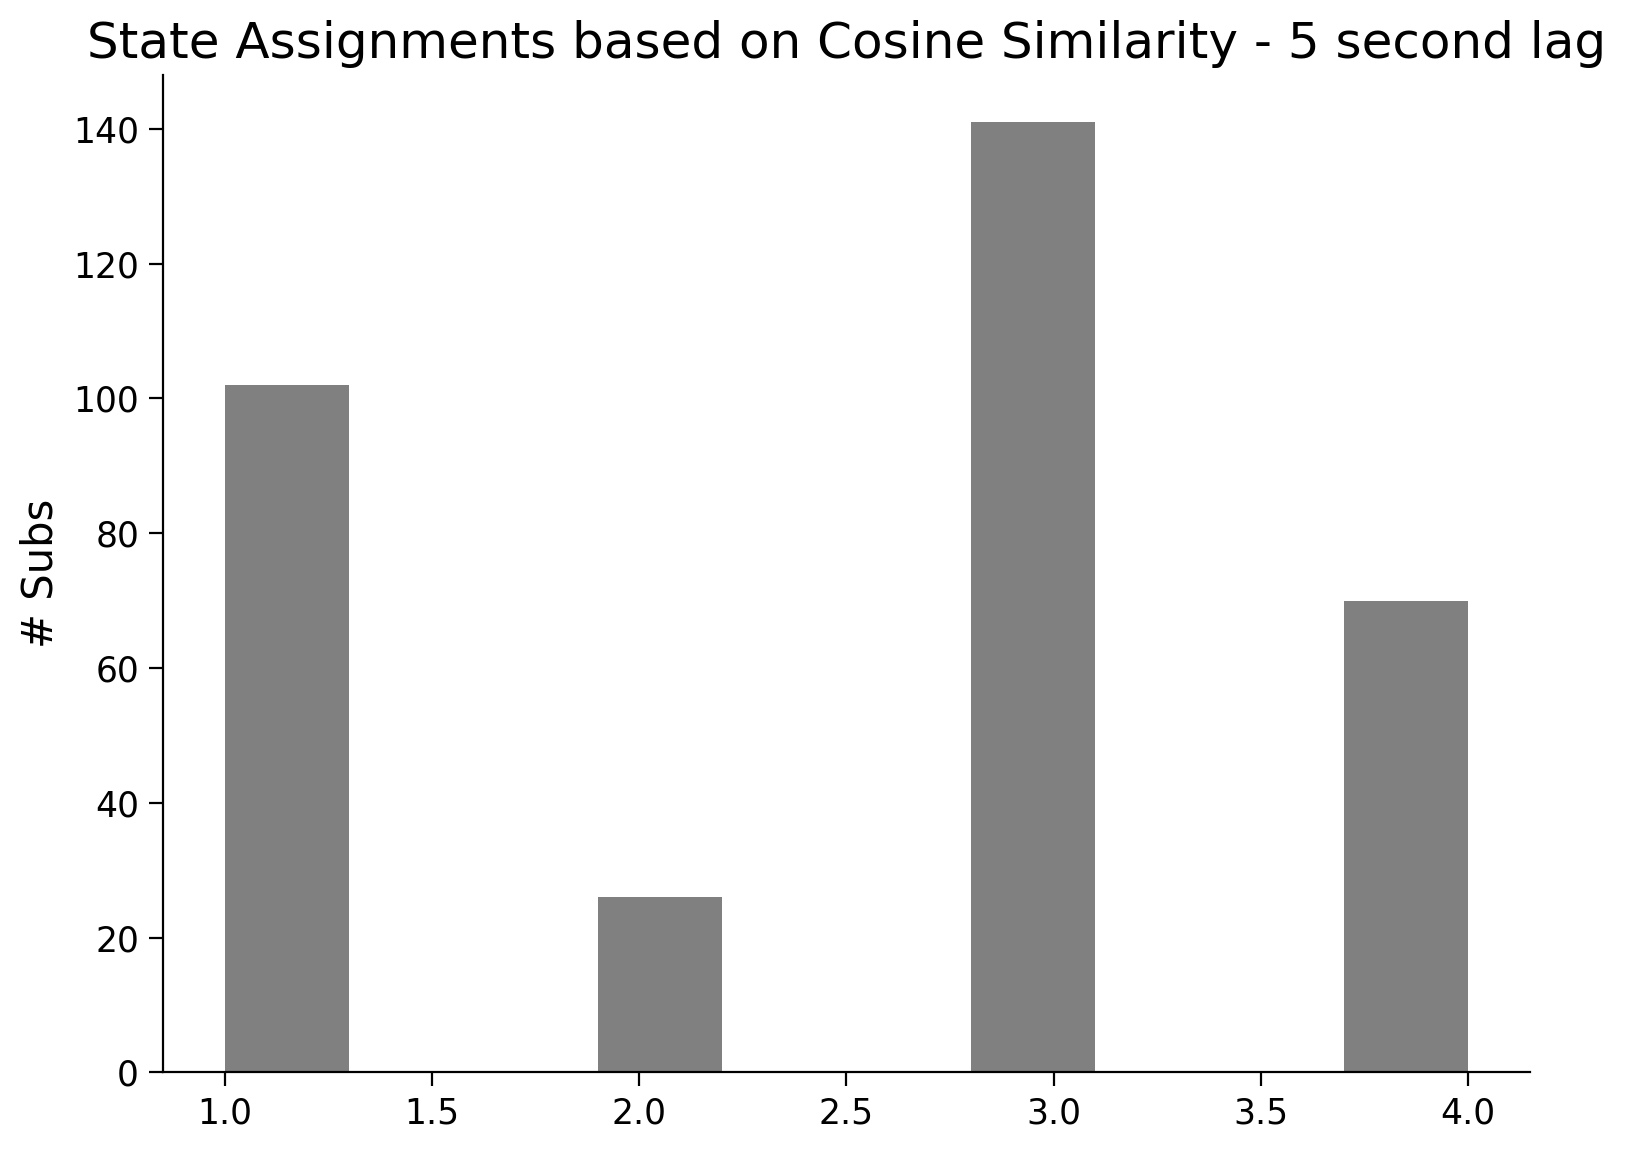

In [ ]:
print(subject_preferred_brainstate)


plt.hist(subject_preferred_brainstate['Mode'],color='grey')
plt.title("State Assignments based on Cosine Similarity - 5 second lag")
plt.ylabel('# Subs')
plt.show()

Mode
3    141
1    100
4     70
2     25
Name: count, dtype: int64
Kruskal-Wallis test: H = 3.959, p = 0.266


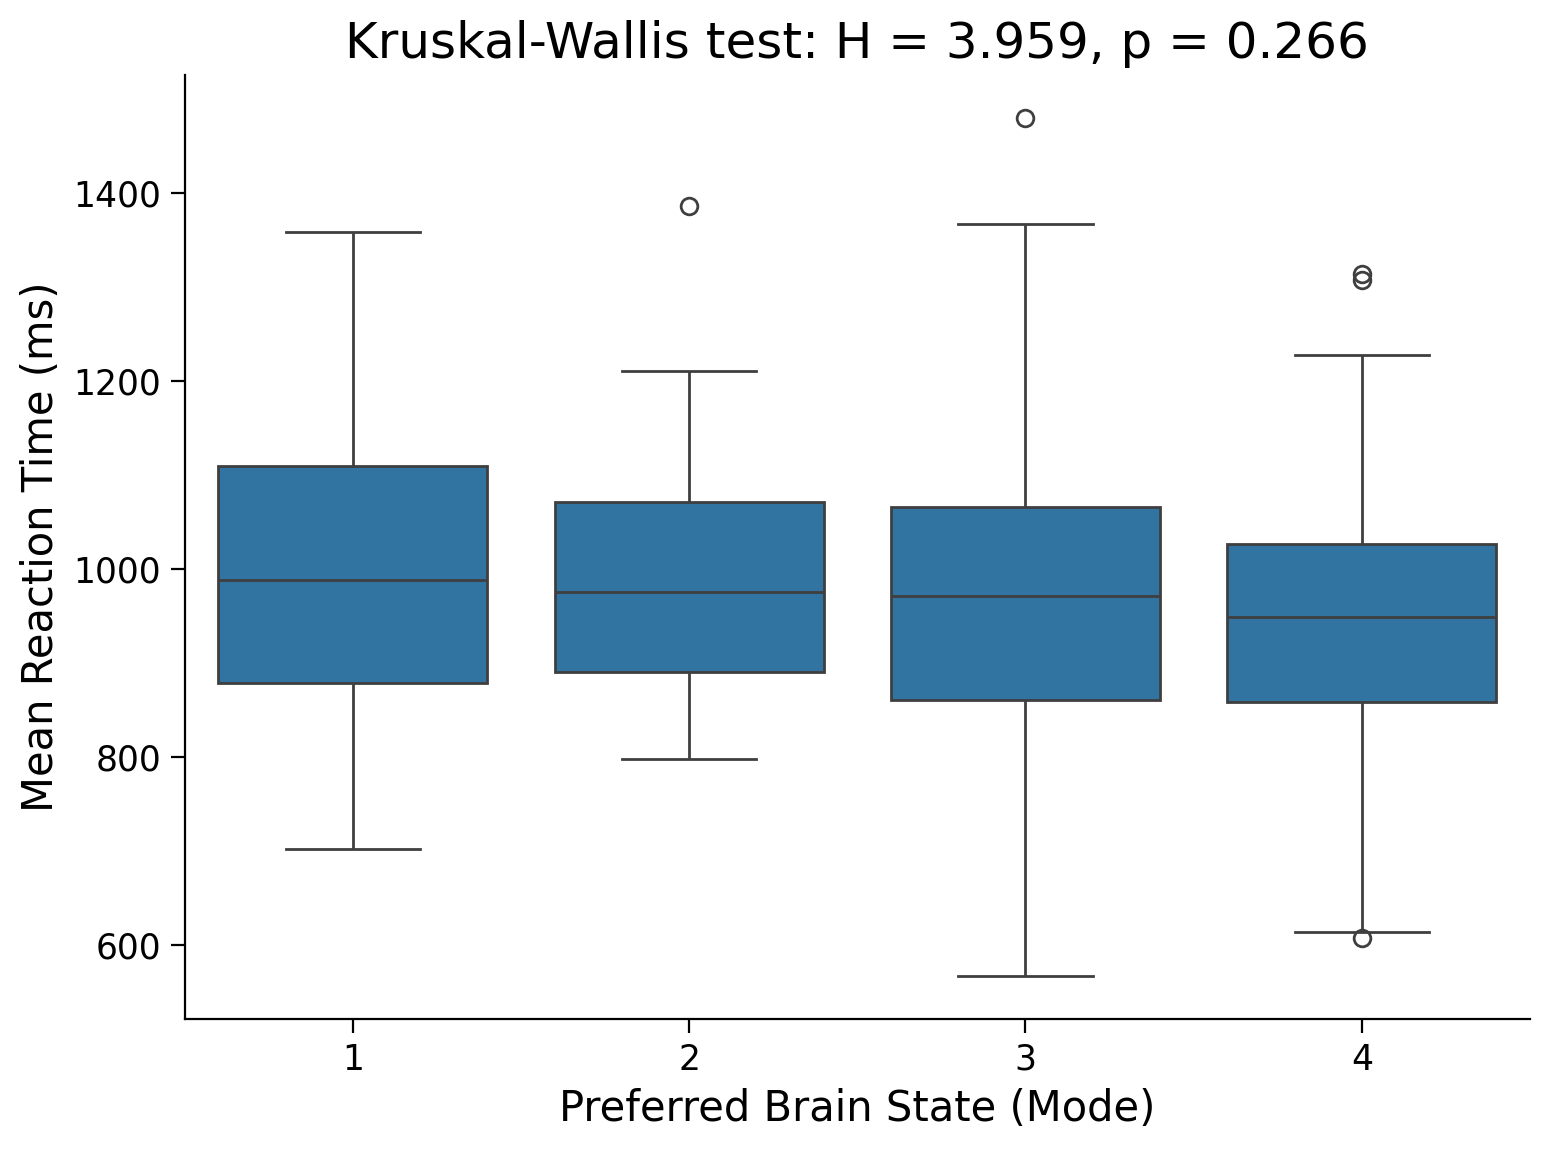

Kruskal-Wallis test (excluding Mode 0): H = 3.959, p = 0.266


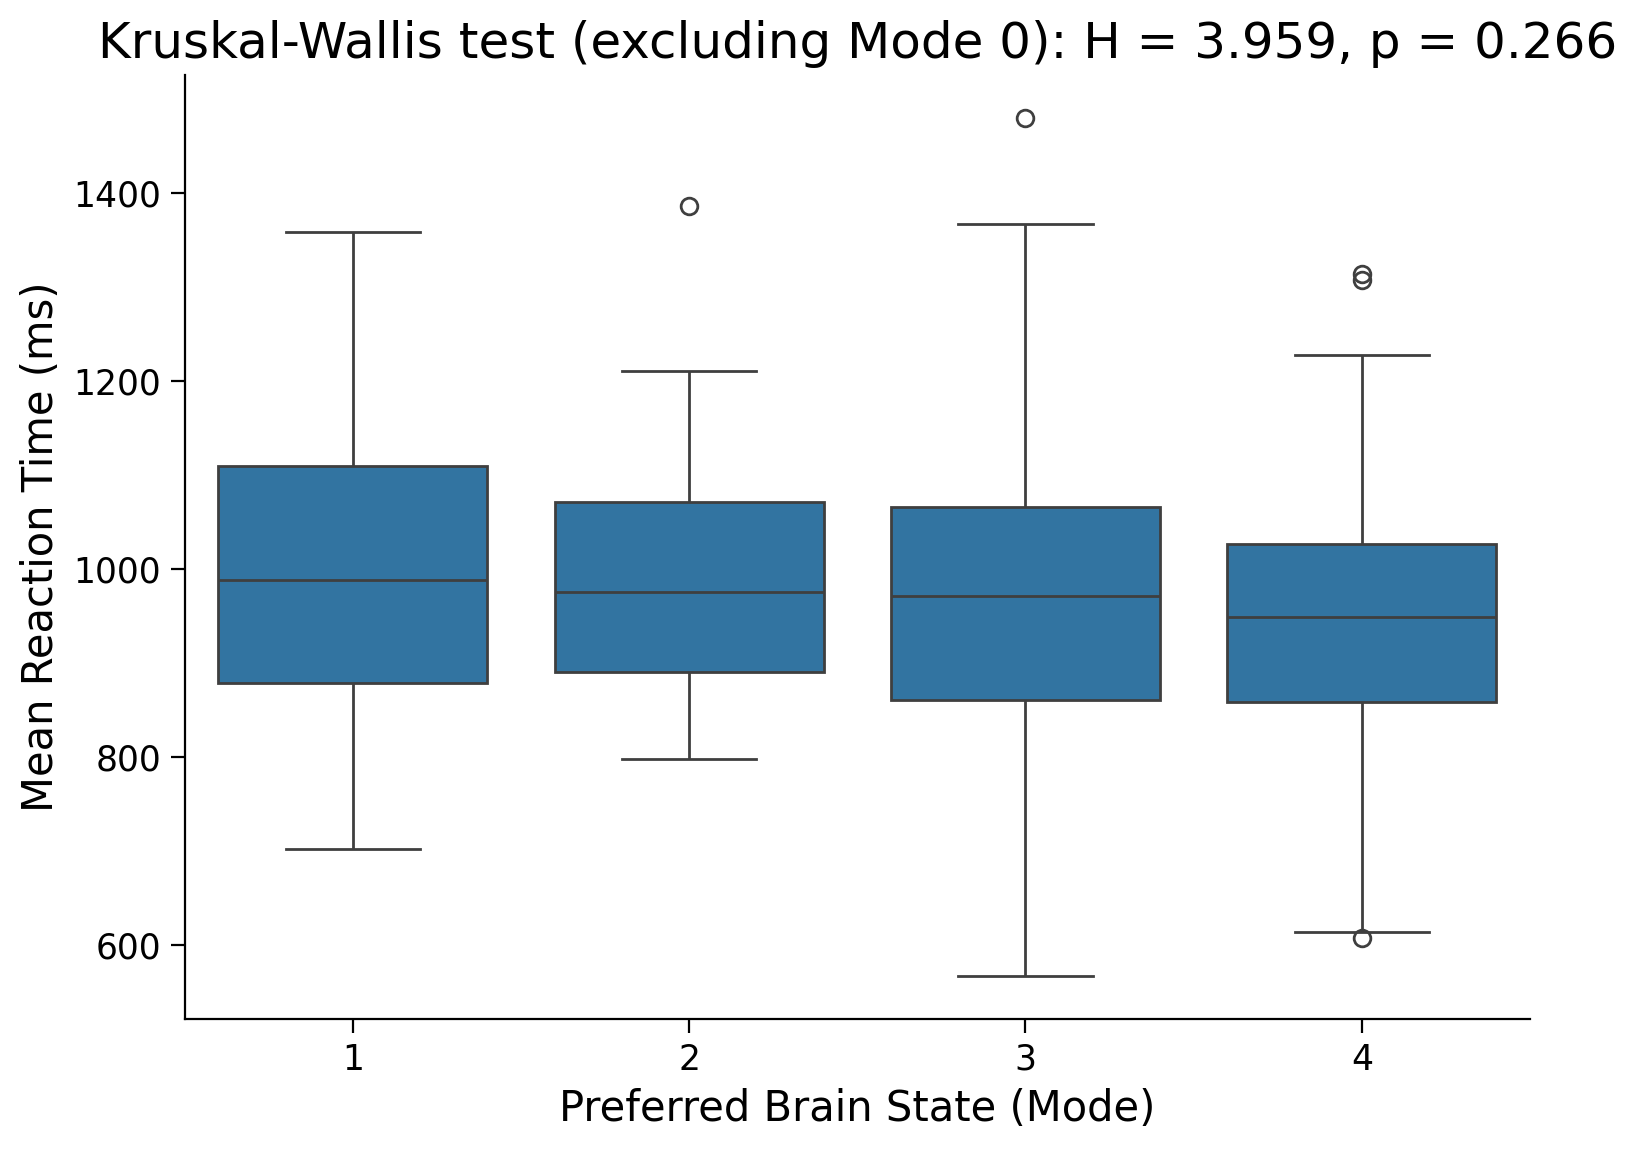

In [ ]:
## - neurobehavioral analysis
from scipy.stats import pearsonr
import scipy.stats as stats

wm_behavior = pd.DataFrame(np.genfromtxt(os.path.join(HCP_DIR, "hcp", "behavior", "wm.csv"),
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf"))


# Get 2-back condition
two_back_df = wm_behavior[wm_behavior['ConditionName'].str.startswith('2BK')]

# Group by subject and get mean median RT across runsand conditions
subject_rt = two_back_df.groupby('Subject')['MEDIAN_RT'].mean()

# - now perform group analysis
df_raw = subject_preferred_brainstate[['Mode']].copy()
df_raw['Mean_RT'] = subject_rt  # assuming subject_rt has matching index

df = df_raw[~df_raw['Mean_RT'].isnull()]            # remove NaNs
df = df[np.isfinite(df['Mean_RT'])]               # remove inf/-inf

print(df['Mode'].value_counts())



groups = [df.loc[df['Mode'] == state, 'Mean_RT'].values for state in sorted(df['Mode'].unique())]

# Check normality and variance assumptions if you want, otherwise:
# If small group sizes or non-normality suspected, do Kruskal-Wallis (non-parametric):
stat, pval = stats.kruskal(*groups)
print(f"Kruskal-Wallis test: H = {stat:.3f}, p = {pval:.3f}")

sns.boxplot(x='Mode', y='Mean_RT', data=df)
plt.xlabel('Preferred Brain State (Mode)')
plt.ylabel('Mean Reaction Time (ms)')
plt.title(f"Kruskal-Wallis test: H = {stat:.3f}, p = {pval:.3f}")
plt.show()






## - exclude brain state 0 because it has way too few subjects
# Filter out Mode 0
df_filtered = df[df['Mode'] != 0]

groups = [df_filtered.loc[df_filtered['Mode'] == state, 'Mean_RT'].values for state in sorted(df_filtered['Mode'].unique())]


stat, pval = stats.kruskal(*groups)
print(f"Kruskal-Wallis test (excluding Mode 0): H = {stat:.3f}, p = {pval:.3f}")

# Plot
sns.boxplot(x='Mode', y='Mean_RT', data=df_filtered)
plt.xlabel('Preferred Brain State (Mode)')
plt.ylabel('Mean Reaction Time (ms)')
plt.title(f"Kruskal-Wallis test (excluding Mode 0): H = {stat:.3f}, p = {pval:.3f}")
plt.show()

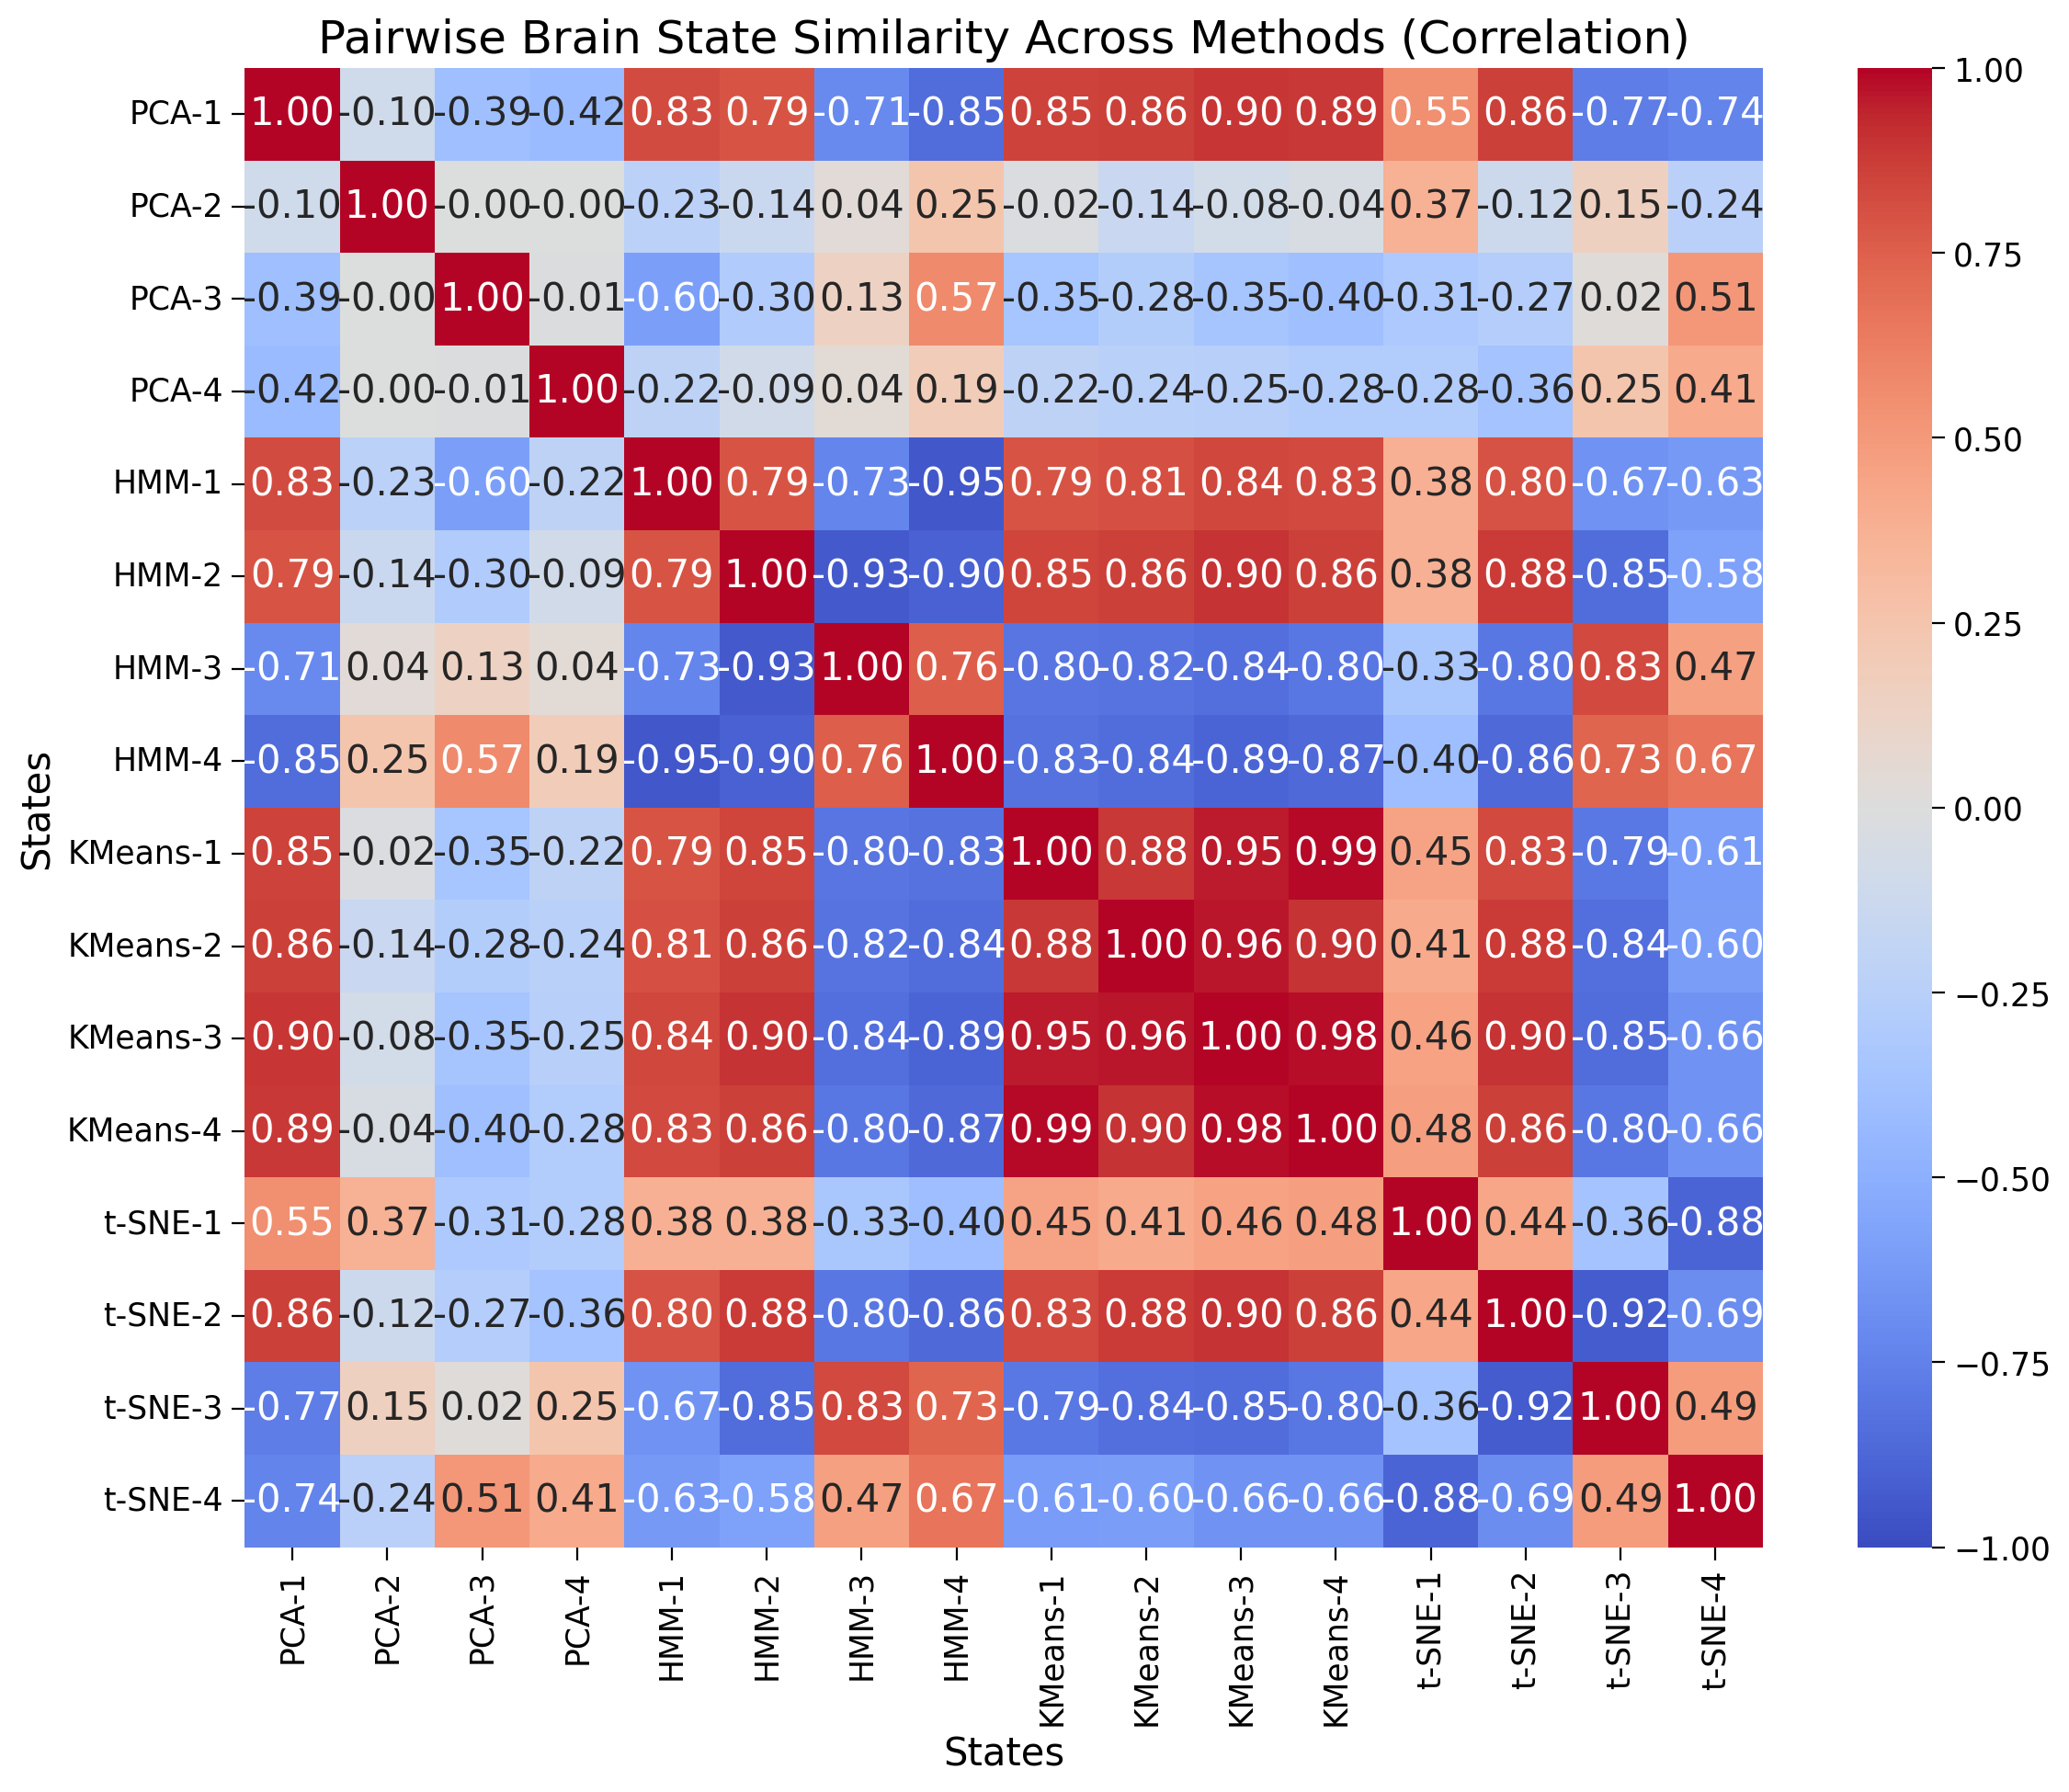

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt

def align_states(A, B, metric='correlation'):
    """
    Align states between two methods using correlation and Hungarian algorithm.

    Args:
        A: array (n_states, n_features)
        B: array (n_states, n_features)
        metric: distance metric for similarity (default 'correlation')

    Returns:
        reordered_B: B reordered to best match A
        similarities: similarity matrix after alignment
        match_indices: alignment indices
    """
    similarity = 1 - cdist(A, B, metric=metric)
    row_ind, col_ind = linear_sum_assignment(-similarity)
    aligned_B = B[col_ind]
    aligned_similarity = similarity[row_ind, col_ind]
    return aligned_B, aligned_similarity, similarity, (row_ind, col_ind)

# === Load data ===
pca_states = np.loadtxt("pca_brain_states.csv", delimiter=",")         # (4, 360)
hmm_states = np.loadtxt("Amber-HMM-timeseries_latent_states_n100_rest.csv", delimiter=",")
kmeans_states = np.loadtxt("dFC_kmeans_states_by_360_parcels_n100.csv", delimiter=",")
tsne_states = np.loadtxt("madion-tsne-formatted.csv", delimiter=",")

method_names = ["PCA", "HMM", "KMeans", "t-SNE"]
methods = [pca_states, hmm_states, kmeans_states, tsne_states]

n_methods = len(methods)
n_states = pca_states.shape[0]

# === Build pairwise similarity matrix between methods ===
big_similarity_matrix = np.zeros((n_methods * n_states, n_methods * n_states))
labels = []

for i in range(n_methods):
    for j in range(n_methods):
        _, _, sim, (row_ind, col_ind) = align_states(methods[i], methods[j])
        # Put similarity into the big matrix
        row_start = i * n_states
        col_start = j * n_states
        big_similarity_matrix[row_start:row_start + n_states, col_start:col_start + n_states] = sim

# === Labels ===
for method in method_names:
    for state in range(1, n_states + 1):
        labels.append(f"{method}-{state}")

# === Plot the full matrix ===
plt.figure(figsize=(12, 10))
sns.heatmap(big_similarity_matrix, xticklabels=labels, yticklabels=labels,
            cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Pairwise Brain State Similarity Across Methods (Correlation)")
plt.xlabel("States")
plt.ylabel("States")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()